First step is to import required libraries and utilities.

In [1]:
# -*- coding: utf-8 -*-
import json # For reading COCO annotations file
import cv2   # For image loading and manipulation
import numpy as np  # For numerical and array operations

from matplotlib import pyplot as plt   # For visualizing images

import os  # For file system access
from ultralytics import YOLO  # Model to train

### STEP I: Visualize Images

First, I set the path to the annotations file. Then I load the file using __json__ library, after which I specifically extract the specific information for the images and their respective annotations.

In [2]:
def return_split_files(split, dataset_folder = "segmentation_dataset", images = True):
    # Path to corresponding COCO annotations file
    if split == "test":
        ANN_PATH = "../extras/extra_coco_annotations.json"
    else:
        ANN_PATH = "../extras/coco_annotations.json"

    # Load annotations file
    file = json.load(open(ANN_PATH, "r"))

    ftype = "images" if images else "labels"
    
    image_base_dir = f"../datasets/{dataset_folder}/{ftype}/{split}"
    image_paths = [os.path.join(image_base_dir, f) for f in os.listdir(image_base_dir)]
    return image_paths

TEST_IMAGE_PATHS = return_split_files("test", "stenosis_dataset", True)
TEST_LABEL_PATHS = return_split_files("test", "stenosis_dataset", False)

### STEP II: Model Training

Now, I train the model. To do this, I need to ensure that the results are repproducible. I also need a configuration file telling the model where to find the data, and what labels to expect in the data.

In [3]:
import torch

In [4]:
# Ensure reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
# Instantiate model
model = YOLO('yolov8s.pt')

In [6]:
print(model)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_s

In [7]:
# Load configuration file
CONFIG_FILE = os.path.join("..", "config", "stenosis_config.yaml")

In [8]:
# Set image size for training
ORIGINAL_IMGSZ = (694, 542)
# IMGSZ = 672
IMGSZ = 640
freeze = 10

In [9]:
# Set folder for artefact storage
folder = "stenosis_yolov8s_freeze"

In [10]:
# Train model
results = model.train(
    data = CONFIG_FILE,
    visualize = True,
    epochs = 150,
    imgsz = IMGSZ,
    optimizer = "Adam",
    lr0 = 1e-3,
    batch = -1,
    pretrained = True,
    freeze = freeze,
    save = True,
    cos_lr = True,
    deterministic = True,
    name = folder
)

Ultralytics YOLOv8.2.0 🚀 Python-3.9.18 torch-2.2.1 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=../config/stenosis_config.yaml, epochs=150, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=stenosis_yolov8s_freeze, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=True, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, sho

/home/harkhymadhe/miniforge3/envs/mri/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1708025831482/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


AMP: checks passed ✅
AutoBatch: Computing optimal batch size for imgsz=640
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU) 8.00G total, 0.26G reserved, 0.13G allocated, 7.62G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    11137148       28.65         0.455         36.68         41.54        (1, 3, 640, 640)                    list
    11137148       57.31         0.447          34.1         21.73        (2, 3, 640, 640)                    list
    11137148       114.6         0.608         32.65         21.22        (4, 3, 640, 640)                    list
    11137148       229.2         1.036         31.97         25.07        (8, 3, 640, 640)                    list
    11137148       458.5         1.680          46.7         31.74       (16, 3, 640, 640)                    list
AutoBatch: Using batch-size 49 for CUDA:0 4.89G/8.00G (61%) ✅


train: Scanning /mnt/c/Users/Harkhymadhe/Desktop/source/export_3/SpineMRI/datasets/stenosis_dataset/labels/train.cache... 61 images, 0 backgrounds, 0 corrupt: 100%|██████████| 61/61 [00:00<?, ?it/s]
val: Scanning /mnt/c/Users/Harkhymadhe/Desktop/source/export_3/SpineMRI/datasets/stenosis_dataset/labels/val.cache... 35 images, 0 backgrounds, 0 corrupt: 100%|██████████| 35/35 [00:00<?, ?it/s]


Plotting labels to runs/detect/stenosis_yolov8s_freeze/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0003828125), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/stenosis_yolov8s_freeze
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      5.16G      5.397      33.16      3.183        124        640: 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

                   all         35        239          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      5.17G      6.177      38.17      3.512        124        640: 100%|██████████| 2/2 [00:00<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]

                   all         35        239          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150       5.1G      5.886      24.92      3.433        155        640: 100%|██████████| 2/2 [00:00<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]

                   all         35        239          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      5.12G      5.656      26.15      3.252        151        640: 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all         35        239          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      5.14G      5.719       26.6      3.514        124        640: 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]

                   all         35        239          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      4.98G      5.997      27.77      3.474        138        640: 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

                   all         35        239          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      5.17G      4.699      7.765      2.263        136        640: 100%|██████████| 2/2 [00:00<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]

                   all         35        239      0.768       0.05     0.0114    0.00321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      5.22G      3.628      3.928      1.516        108        640: 100%|██████████| 2/2 [00:00<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]

                   all         35        239      0.773      0.129     0.0167     0.0042



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      5.17G      3.476      3.039       1.45        130        640: 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]

                   all         35        239      0.772     0.0737     0.0161    0.00411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      5.16G       3.18      2.724      1.308        152        640: 100%|██████████| 2/2 [00:00<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]

                   all         35        239      0.772     0.0947     0.0162     0.0051



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      5.13G      2.957      2.562      1.299        133        640: 100%|██████████| 2/2 [00:00<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

                   all         35        239    0.00968      0.161     0.0152    0.00548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      5.21G        2.8      2.606      1.195        138        640: 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.91it/s]

                   all         35        239     0.0121      0.161     0.0161    0.00638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      5.25G      2.825      2.531      1.116        150        640: 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]

                   all         35        239     0.0123      0.147     0.0138    0.00503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      5.22G      2.763       2.58       1.18         85        640: 100%|██████████| 2/2 [00:00<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]

                   all         35        239    0.00507      0.155    0.00805    0.00291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      5.16G       2.68       2.42      1.129        142        640: 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         35        239    0.00384      0.145    0.00752    0.00253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      5.22G      2.596      2.347      1.119        116        640: 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]

                   all         35        239      0.514     0.0195     0.0137    0.00416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      5.11G      2.546      2.243      1.091        146        640: 100%|██████████| 2/2 [00:00<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]

                   all         35        239      0.268      0.032    0.00984    0.00348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      5.21G      2.662      2.258      1.101        128        640: 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

                   all         35        239      0.518     0.0132     0.0114    0.00228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      5.14G      2.598      2.167      1.105        110        640: 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]

                   all         35        239      0.265     0.0105    0.00831    0.00237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      5.22G       2.61      2.089      1.044        143        640: 100%|██████████| 2/2 [00:00<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]

                   all         35        239      0.304     0.0236     0.0105    0.00307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      5.25G      2.528      2.113      1.055        166        640: 100%|██████████| 2/2 [00:00<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]

                   all         35        239       0.56     0.0419     0.0259    0.00622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      5.21G      2.531      2.002        1.1        150        640: 100%|██████████| 2/2 [00:00<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

                   all         35        239      0.316      0.109     0.0311    0.00798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      5.16G      2.392      1.904      1.066        121        640: 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]

                   all         35        239      0.334      0.169     0.0524     0.0131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      5.19G      2.498      1.883      1.128        126        640: 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]

                   all         35        239      0.431      0.147     0.0678     0.0176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      5.17G      2.348      1.921      1.026        127        640: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

                   all         35        239      0.345       0.15      0.077     0.0207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      5.17G      2.356      1.852      1.056        125        640: 100%|██████████| 2/2 [00:00<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]

                   all         35        239      0.591      0.166     0.0915     0.0281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      5.14G      2.238      1.817      1.061        100        640: 100%|██████████| 2/2 [00:00<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]

                   all         35        239      0.605      0.148     0.0891     0.0278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      5.18G      2.323      1.726      1.064        103        640: 100%|██████████| 2/2 [00:00<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

                   all         35        239      0.393      0.177     0.0943      0.033



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      5.13G      2.267       1.78      1.056        119        640: 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all         35        239      0.366      0.194      0.112     0.0376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      5.19G      2.302      1.734      1.036        139        640: 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

                   all         35        239      0.403      0.235      0.117     0.0386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      5.18G      2.251      1.726      1.018        123        640: 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]

                   all         35        239      0.374       0.23      0.101     0.0352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      5.24G      2.192      1.729      1.043        116        640: 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

                   all         35        239       0.37      0.218     0.0979     0.0316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      5.16G      2.124      1.644      1.025         91        640: 100%|██████████| 2/2 [00:00<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

                   all         35        239      0.381      0.284      0.113     0.0349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      5.24G      2.174      1.598      1.018        143        640: 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]

                   all         35        239       0.39      0.216      0.107     0.0347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      5.24G      2.127      1.538      1.008        158        640: 100%|██████████| 2/2 [00:00<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

                   all         35        239      0.428      0.241      0.145     0.0503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      5.15G      2.169      1.564      1.008        160        640: 100%|██████████| 2/2 [00:00<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]

                   all         35        239      0.416      0.279       0.16     0.0575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      5.13G      2.064      1.629      1.016         63        640: 100%|██████████| 2/2 [00:00<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

                   all         35        239      0.455      0.259      0.166      0.059



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      5.24G      1.968      1.465     0.9911         88        640: 100%|██████████| 2/2 [00:00<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]

                   all         35        239      0.452      0.284      0.184     0.0699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      5.13G      2.076      1.514      0.991        176        640: 100%|██████████| 2/2 [00:00<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

                   all         35        239      0.479      0.283      0.191     0.0726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      5.18G      1.968      1.459     0.9695        168        640: 100%|██████████| 2/2 [00:00<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

                   all         35        239      0.431      0.338      0.165     0.0569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      5.14G      2.098       1.51     0.9728        103        640: 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]

                   all         35        239      0.402      0.345      0.137     0.0468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      5.24G      2.075      1.545      1.058        106        640: 100%|██████████| 2/2 [00:00<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]

                   all         35        239      0.504      0.249        0.2      0.072



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      5.25G      2.054       1.51      1.014        126        640: 100%|██████████| 2/2 [00:00<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

                   all         35        239       0.48      0.299      0.194      0.071



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      5.19G      1.988      1.466     0.9937        141        640: 100%|██████████| 2/2 [00:00<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

                   all         35        239      0.173      0.355      0.172     0.0615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      5.13G       2.05       1.48     0.9485        149        640: 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]

                   all         35        239      0.211      0.359      0.209     0.0779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      5.25G      1.973      1.443     0.9564         98        640: 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

                   all         35        239      0.547      0.338      0.256      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      5.24G      1.928      1.382     0.9644        124        640: 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]

                   all         35        239      0.543      0.345      0.264       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      5.25G      1.977      1.387     0.9888         84        640: 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]

                   all         35        239      0.552      0.367      0.298      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      5.17G      1.958      1.346      0.939        146        640: 100%|██████████| 2/2 [00:00<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]

                   all         35        239      0.559      0.393      0.281      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      5.16G      1.946      1.399     0.9915        104        640: 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

                   all         35        239      0.546      0.331      0.262     0.0867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      5.24G      2.077      1.637      1.028         75        640: 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

                   all         35        239      0.512      0.379      0.248     0.0896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      5.17G      2.013       1.44     0.9754        146        640: 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]

                   all         35        239       0.55      0.347      0.287      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      5.24G       2.03      1.449     0.9685        116        640: 100%|██████████| 2/2 [00:00<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

                   all         35        239      0.553      0.348        0.3      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      5.18G      2.131      1.432     0.9756        143        640: 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

                   all         35        239      0.538       0.39      0.289      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      5.25G      1.971      1.484     0.9721        153        640: 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all         35        239      0.503      0.406      0.261     0.0976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      5.18G      2.003      1.387     0.9793        122        640: 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]

                   all         35        239      0.517      0.295      0.243     0.0844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      5.09G      1.891      1.422     0.9621        112        640: 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

                   all         35        239      0.495      0.318      0.197     0.0691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      5.22G      1.909      1.415      0.943        189        640: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]

                   all         35        239      0.489      0.297      0.196     0.0665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      5.24G      1.798      1.313      0.956        118        640: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

                   all         35        239      0.468      0.311      0.213     0.0751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      5.19G      1.801      1.334      0.935        129        640: 100%|██████████| 2/2 [00:00<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

                   all         35        239      0.525      0.366      0.274     0.0959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      5.25G      1.824      1.328     0.9529        108        640: 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

                   all         35        239      0.576       0.33       0.29      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      5.22G      1.962      1.382     0.9582        157        640: 100%|██████████| 2/2 [00:00<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

                   all         35        239      0.498      0.388      0.281     0.0995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      5.25G      1.767      1.234     0.9191        109        640: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]

                   all         35        239      0.567      0.346      0.281      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      5.22G      1.832      1.316     0.9316        119        640: 100%|██████████| 2/2 [00:00<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]

                   all         35        239       0.71      0.344      0.315       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      5.13G       1.77      1.208     0.9238        130        640: 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

                   all         35        239      0.606       0.34        0.3      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      5.18G      1.785       1.19     0.9336        117        640: 100%|██████████| 2/2 [00:00<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

                   all         35        239       0.55      0.384      0.309      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      5.25G      1.806      1.217     0.9588        154        640: 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]

                   all         35        239       0.56      0.396       0.31      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      5.17G       1.88      1.252     0.9239        137        640: 100%|██████████| 2/2 [00:00<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]

                   all         35        239      0.601      0.304      0.323       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      5.25G      1.787      1.257     0.9319        149        640: 100%|██████████| 2/2 [00:00<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]

                   all         35        239      0.505      0.359        0.3       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      5.24G      1.956      1.356     0.9431        150        640: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]

                   all         35        239      0.575      0.299       0.29      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      5.24G      1.864      1.258     0.9414        101        640: 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]

                   all         35        239      0.485      0.389      0.308      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      5.25G      1.889      1.223     0.9279        158        640: 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]

                   all         35        239      0.495      0.397      0.311      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      5.13G      1.816      1.196     0.9482        140        640: 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

                   all         35        239      0.545      0.403      0.335      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      5.24G      1.765      1.198     0.9273        110        640: 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]

                   all         35        239      0.545      0.411      0.333      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150       5.2G      1.765      1.236     0.9556        129        640: 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

                   all         35        239      0.562      0.376      0.327      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      5.22G      1.697      1.176     0.9755         63        640: 100%|██████████| 2/2 [00:00<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

                   all         35        239      0.581      0.319      0.324      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      5.15G      1.776       1.26     0.9038        149        640: 100%|██████████| 2/2 [00:00<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]

                   all         35        239      0.674      0.274        0.3      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      5.22G       1.77      1.302     0.9416        137        640: 100%|██████████| 2/2 [00:00<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         35        239      0.645      0.276      0.301      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      5.18G      1.658      1.165     0.9218        140        640: 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]

                   all         35        239       0.26      0.411      0.318      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      5.19G      1.639       1.14     0.9309        117        640: 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

                   all         35        239      0.532      0.358      0.339      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      5.18G      1.683      1.177     0.9221        112        640: 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]

                   all         35        239      0.559      0.351      0.352      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      5.16G      1.683      1.105     0.9213        113        640: 100%|██████████| 2/2 [00:00<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         35        239       0.58      0.339      0.351      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      5.24G      1.668      1.147     0.8906        122        640: 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

                   all         35        239       0.54      0.407      0.328      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      5.08G      1.715      1.113     0.9399        153        640: 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]

                   all         35        239      0.516      0.385      0.322      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      5.24G      1.749      1.146     0.9204        166        640: 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]

                   all         35        239      0.509      0.373      0.325      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      5.22G      1.722      1.204     0.9383         96        640: 100%|██████████| 2/2 [00:00<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

                   all         35        239      0.565      0.268      0.297      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      5.21G      1.673       1.13     0.9003        157        640: 100%|██████████| 2/2 [00:00<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]

                   all         35        239      0.565      0.281      0.284      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      5.24G      1.639      1.089     0.9314         96        640: 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]

                   all         35        239      0.548      0.277      0.282      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      5.11G      1.695      1.082     0.8893        210        640: 100%|██████████| 2/2 [00:00<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]

                   all         35        239       0.52      0.334      0.291      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      5.16G       1.61      1.069     0.8883        127        640: 100%|██████████| 2/2 [00:00<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]

                   all         35        239      0.519      0.335      0.293      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      5.16G      1.625      1.178     0.9418         95        640: 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

                   all         35        239      0.535      0.361      0.318      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      5.17G      1.677      1.179     0.9389         98        640: 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]

                   all         35        239      0.547      0.403      0.347      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      5.25G      1.686      1.153     0.9261        136        640: 100%|██████████| 2/2 [00:00<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

                   all         35        239      0.542      0.435      0.352      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150       5.2G      1.588      1.091     0.8837        127        640: 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

                   all         35        239      0.538      0.423      0.333      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      5.24G      1.586      1.104     0.9155        125        640: 100%|██████████| 2/2 [00:00<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

                   all         35        239      0.538      0.414      0.331      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      5.19G      1.619      1.112     0.9252        103        640: 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

                   all         35        239      0.522      0.406      0.341      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      5.13G      1.631      1.121     0.9398         79        640: 100%|██████████| 2/2 [00:00<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

                   all         35        239      0.639       0.31      0.349      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      5.21G      1.637      1.083     0.9004        153        640: 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

                   all         35        239      0.519      0.399      0.353      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150       5.2G      1.546      1.067     0.8857        104        640: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

                   all         35        239      0.534      0.401      0.356      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      5.22G      1.605      1.069     0.9032        123        640: 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]

                   all         35        239      0.545      0.417       0.36      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      5.22G      1.589      1.003     0.8994        126        640: 100%|██████████| 2/2 [00:00<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         35        239      0.559      0.439      0.363      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      5.22G      1.562     0.9821     0.8838        126        640: 100%|██████████| 2/2 [00:00<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

                   all         35        239       0.58      0.457      0.377      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      5.22G      1.475     0.9789     0.8724        151        640: 100%|██████████| 2/2 [00:00<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]

                   all         35        239      0.562      0.428      0.378      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      5.19G      1.528      1.006     0.8973        119        640: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]

                   all         35        239      0.576      0.444      0.376      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      5.13G      1.504      1.032     0.8938        114        640: 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]

                   all         35        239      0.566      0.402      0.377      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      5.18G      1.471     0.9769      0.877        108        640: 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

                   all         35        239      0.556      0.398      0.372      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      5.21G      1.436      1.015     0.8678        118        640: 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]

                   all         35        239      0.559       0.39      0.376      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      5.25G      1.477      1.014     0.8731        143        640: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]

                   all         35        239      0.585      0.423      0.379      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      5.22G      1.531     0.9761     0.8904        108        640: 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

                   all         35        239      0.577      0.435      0.367      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      5.24G       1.51     0.9776     0.8731        136        640: 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

                   all         35        239      0.574      0.425      0.359      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      5.17G      1.452     0.9574     0.8698        151        640: 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]

                   all         35        239      0.564      0.408      0.357      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      5.22G      1.485     0.9929     0.8838        162        640: 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]

                   all         35        239       0.55      0.374      0.347      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150       5.1G      1.374     0.9118     0.8674        154        640: 100%|██████████| 2/2 [00:00<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

                   all         35        239      0.575       0.41      0.363      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      5.22G      1.502     0.9531     0.8872        151        640: 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

                   all         35        239      0.563      0.375      0.365      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      5.18G      1.466     0.9791      0.914        111        640: 100%|██████████| 2/2 [00:00<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]

                   all         35        239      0.577      0.384      0.378      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      5.08G       1.47     0.9718     0.8993        111        640: 100%|██████████| 2/2 [00:00<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

                   all         35        239      0.575      0.379      0.371      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      5.22G      1.436     0.9924     0.8964         75        640: 100%|██████████| 2/2 [00:00<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]

                   all         35        239      0.614      0.376      0.374      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      5.21G      1.435     0.9702     0.8759        126        640: 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]

                   all         35        239      0.616      0.371      0.371      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      5.22G      1.476      1.007     0.8905        116        640: 100%|██████████| 2/2 [00:00<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

                   all         35        239      0.614      0.368      0.371      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      5.21G      1.435     0.9369     0.8754        139        640: 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

                   all         35        239      0.604      0.378      0.371      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      5.11G      1.501     0.9489     0.8628        165        640: 100%|██████████| 2/2 [00:00<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]

                   all         35        239      0.614      0.371      0.376      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      5.21G       1.51      1.025     0.9063        112        640: 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

                   all         35        239      0.613      0.375      0.376      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150       5.2G       1.48     0.9802     0.8909        110        640: 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

                   all         35        239      0.613      0.375      0.378      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150       5.2G      1.401      0.928     0.8819        105        640: 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]

                   all         35        239      0.608      0.377       0.38      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      5.25G      1.478     0.9211     0.8569        169        640: 100%|██████████| 2/2 [00:00<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

                   all         35        239      0.632      0.372      0.385      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      5.25G       1.43     0.9259      0.869        125        640: 100%|██████████| 2/2 [00:00<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

                   all         35        239      0.621      0.362       0.38       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      5.22G      1.407      1.003     0.8782         92        640: 100%|██████████| 2/2 [00:00<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]

                   all         35        239      0.614      0.357      0.372      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      5.22G      1.417     0.9481     0.8506        143        640: 100%|██████████| 2/2 [00:00<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

                   all         35        239       0.63      0.357      0.371      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      5.11G      1.444     0.9165     0.8878        104        640: 100%|██████████| 2/2 [00:00<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

                   all         35        239      0.618      0.357       0.37      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      5.24G      1.427     0.9425     0.8866         97        640: 100%|██████████| 2/2 [00:00<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

                   all         35        239      0.606      0.355      0.368      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      5.25G      1.481     0.9487     0.8661        190        640: 100%|██████████| 2/2 [00:00<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

                   all         35        239      0.608      0.352      0.376      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150       5.2G      1.402     0.9346     0.8843        145        640: 100%|██████████| 2/2 [00:00<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

                   all         35        239      0.621       0.35      0.373      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      5.24G      1.422      0.907     0.8711        134        640: 100%|██████████| 2/2 [00:00<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

                   all         35        239      0.623      0.348      0.369      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      5.22G      1.455     0.9407     0.9076        103        640: 100%|██████████| 2/2 [00:00<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]

                   all         35        239      0.606      0.367       0.37      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      5.22G      1.427     0.9495     0.8826        122        640: 100%|██████████| 2/2 [00:00<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

                   all         35        239       0.59      0.361       0.37      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      5.25G      1.393     0.8946     0.9059        105        640: 100%|██████████| 2/2 [00:00<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

                   all         35        239      0.596      0.368      0.368      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      5.25G      1.331      0.897     0.8615        115        640: 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

                   all         35        239      0.588      0.366      0.374      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      5.24G      1.344     0.8693     0.8681        109        640: 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         35        239      0.567       0.41      0.372      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      5.25G      1.395     0.9116     0.8709        147        640: 100%|██████████| 2/2 [00:00<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

                   all         35        239        0.6      0.369      0.368      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      5.16G      1.339     0.9034     0.8618        105        640: 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]

                   all         35        239      0.588      0.363      0.372      0.149


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      4.94G      1.336     0.9106     0.8914         75        640: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]

                   all         35        239      0.563      0.404      0.368      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      4.95G      1.327     0.8846     0.8755         83        640: 100%|██████████| 2/2 [00:00<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

                   all         35        239      0.568       0.41      0.365      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      4.95G      1.398      0.963     0.9026         85        640: 100%|██████████| 2/2 [00:00<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         35        239      0.584      0.432       0.37      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      4.94G       1.25     0.8456     0.8848         79        640: 100%|██████████| 2/2 [00:00<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

                   all         35        239      0.588      0.434      0.374      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      4.95G      1.464     0.9136     0.8617         78        640: 100%|██████████| 2/2 [00:00<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

                   all         35        239      0.582      0.432      0.369      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      4.95G      1.287     0.8671     0.8719         75        640: 100%|██████████| 2/2 [00:00<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

                   all         35        239      0.586      0.422      0.368      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      4.95G       1.36     0.9073     0.9028         83        640: 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

                   all         35        239      0.605      0.409      0.369      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      4.95G      1.412     0.9239     0.8914         85        640: 100%|██████████| 2/2 [00:00<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]

                   all         35        239      0.605      0.394      0.369      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      4.94G      1.343     0.9354     0.8786         80        640: 100%|██████████| 2/2 [00:00<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

                   all         35        239        0.6      0.386      0.362      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      4.95G       1.39     0.8779      0.882         84        640: 100%|██████████| 2/2 [00:00<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]

                   all         35        239      0.604      0.385      0.363      0.144



150 epochs completed in 0.060 hours.
Optimizer stripped from runs/detect/stenosis_yolov8s_freeze/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/stenosis_yolov8s_freeze/weights/best.pt, 22.5MB

Validating runs/detect/stenosis_yolov8s_freeze/weights/best.pt...
Ultralytics YOLOv8.2.0 🚀 Python-3.9.18 torch-2.2.1 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)
Model summary (fused): 168 layers, 11127132 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


                   all         35        239      0.559      0.387      0.374      0.154
      Grade 0 Stenosis         35         12          1          0          0          0
      Grade 1 Stenosis         35         24      0.272      0.202      0.307      0.114
      Grade 2 Stenosis         35         95      0.412      0.632      0.527      0.245
      Grade 3 Stenosis         35        108       0.55      0.713      0.663      0.258
Speed: 0.2ms preprocess, 5.8ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/stenosis_yolov8s_freeze


In [11]:
results

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fade26448e0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [12]:
def return_split_files(split, dataset_folder = "stenosis_dataset", images = True):
    # Path to corresponding COCO annotations file
    if split == "test":
        ANN_PATH = "../extras/extra_coco_annotations.json"
    else:
        ANN_PATH = "../extras/coco_annotations.json"

    # Load annotations file
    file = json.load(open(ANN_PATH, "r"))

    ftype = "images" if images else "labels"
    
    image_base_dir = f"../datasets/{dataset_folder}/{ftype}/{split}"
    image_paths = [os.path.join(image_base_dir, f) for f in os.listdir(image_base_dir)]
    return image_paths

---

Now we test the evaluate the model.

In [13]:
del model

In [14]:
import gc
gc.collect()

53593

In [15]:
# Instantiate model
model = YOLO('runs/detect/stenosis_yolov8s_freeze/weights/best.pt')

In [16]:
# Evaluate model performance on train set
model.val(split = "train", name = folder)

Ultralytics YOLOv8.2.0 🚀 Python-3.9.18 torch-2.2.1 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)
Model summary (fused): 168 layers, 11127132 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /mnt/c/Users/Harkhymadhe/Desktop/source/export_3/SpineMRI/datasets/stenosis_dataset/labels/train.cache... 61 images, 0 backgrounds, 0 corrupt: 100%|██████████| 61/61 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


                   all         61        412      0.924      0.485      0.604      0.357
      Grade 0 Stenosis         61         26          1          0    0.00967    0.00216
      Grade 1 Stenosis         61         31       0.95      0.484      0.701      0.416
      Grade 2 Stenosis         61        207      0.921      0.691      0.875      0.552
      Grade 3 Stenosis         61        148      0.826      0.764      0.828      0.457
Speed: 0.8ms preprocess, 16.1ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/detect/stenosis_yolov8s_freeze2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fade2cd2ac0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [17]:
# Evaluate model performance on val set
model.val(split = "val", name = folder)

Ultralytics YOLOv8.2.0 🚀 Python-3.9.18 torch-2.2.1 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)


val: Scanning /mnt/c/Users/Harkhymadhe/Desktop/source/export_3/SpineMRI/datasets/stenosis_dataset/labels/val.cache... 35 images, 0 backgrounds, 0 corrupt: 100%|██████████| 35/35 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]


                   all         35        239      0.559       0.39      0.378      0.154
      Grade 0 Stenosis         35         12          1          0          0          0
      Grade 1 Stenosis         35         24      0.267      0.198      0.313      0.113
      Grade 2 Stenosis         35         95      0.426      0.648      0.535      0.249
      Grade 3 Stenosis         35        108      0.543      0.713      0.666      0.256
Speed: 0.7ms preprocess, 19.2ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/detect/stenosis_yolov8s_freeze3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fade28308e0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [18]:
# Evaluate model performance on test set
model.val(split = "test", name = folder)

Ultralytics YOLOv8.2.0 🚀 Python-3.9.18 torch-2.2.1 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)


val: Scanning /mnt/c/Users/Harkhymadhe/Desktop/source/export_3/SpineMRI/datasets/stenosis_dataset/labels/test.cache... 38 images, 0 backgrounds, 0 corrupt: 100%|██████████| 38/38 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]


                   all         38        234       0.45      0.315      0.239     0.0784
      Grade 0 Stenosis         38         20          1          0          0          0
      Grade 1 Stenosis         38          4          0          0     0.0243     0.0102
      Grade 2 Stenosis         38         98      0.425      0.497      0.363      0.109
      Grade 3 Stenosis         38        112      0.374      0.763       0.57      0.194
Speed: 9.4ms preprocess, 27.3ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/stenosis_yolov8s_freeze4


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7faee72c2070>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

---

Now we test the model to visualize predictions.

In [19]:
TEST_IMAGE_PATHS = return_split_files("train", "stenosis_dataset", True)
TEST_LABEL_PATHS = return_split_files("train", "stenosis_dataset", False)

In [20]:
conf = .25

In [21]:
PREDS = model.predict(
    TEST_IMAGE_PATHS,
    imgsz = 640,
    conf = conf,
    agnostic_nms = True,
    iou = .8,
    show_boxes = False,
)

0: 512x640 1 Grade 2 Stenosis, 7 Grade 3 Stenosiss, 6.3ms
1: 512x640 1 Grade 2 Stenosis, 7 Grade 3 Stenosiss, 6.3ms
2: 512x640 6 Grade 3 Stenosiss, 6.3ms
3: 512x640 6 Grade 2 Stenosiss, 6.3ms
4: 512x640 7 Grade 2 Stenosiss, 6.3ms
5: 512x640 6 Grade 2 Stenosiss, 6.3ms
6: 512x640 5 Grade 2 Stenosiss, 6.3ms
7: 512x640 5 Grade 2 Stenosiss, 6.3ms
8: 512x640 5 Grade 2 Stenosiss, 1 Grade 3 Stenosis, 6.3ms
9: 512x640 6 Grade 2 Stenosiss, 6.3ms
10: 512x640 4 Grade 2 Stenosiss, 2 Grade 3 Stenosiss, 6.3ms
11: 512x640 5 Grade 2 Stenosiss, 3 Grade 3 Stenosiss, 6.3ms
12: 512x640 4 Grade 2 Stenosiss, 2 Grade 3 Stenosiss, 6.3ms
13: 512x640 7 Grade 2 Stenosiss, 6.3ms
14: 512x640 6 Grade 2 Stenosiss, 6.3ms
15: 512x640 7 Grade 2 Stenosiss, 6.3ms
16: 512x640 7 Grade 2 Stenosiss, 6.3ms
17: 512x640 2 Grade 2 Stenosiss, 2 Grade 3 Stenosiss, 6.3ms
18: 512x640 4 Grade 2 Stenosiss, 1 Grade 3 Stenosis, 6.3ms
19: 512x640 6 Grade 2 Stenosiss, 6.3ms
20: 512x640 2 Grade 2 Stenosiss, 5 Grade 3 Stenosiss, 6.3ms
21: 51

In [22]:
pred_masks = [mask.boxes.cpu().data.numpy() for mask in PREDS]

In [23]:
PREDS[2].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([3., 3., 3., 3., 3., 3.], device='cuda:0')
conf: tensor([0.8969, 0.8594, 0.8413, 0.6474, 0.6310, 0.3340], device='cuda:0')
data: tensor([[3.9680e+02, 3.1928e+02, 4.2676e+02, 3.3748e+02, 8.9688e-01, 3.0000e+00],
        [3.9621e+02, 2.8709e+02, 4.2567e+02, 3.0249e+02, 8.5938e-01, 3.0000e+00],
        [3.9732e+02, 2.5694e+02, 4.2708e+02, 2.7352e+02, 8.4134e-01, 3.0000e+00],
        [3.9877e+02, 2.2103e+02, 4.2996e+02, 2.3474e+02, 6.4741e-01, 3.0000e+00],
        [4.0325e+02, 3.5177e+02, 4.3471e+02, 3.6485e+02, 6.3101e-01, 3.0000e+00],
        [3.9502e+02, 2.8603e+02, 4.2478e+02, 3.0416e+02, 3.3401e-01, 3.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (542, 694)
shape: torch.Size([6, 6])
xywh: tensor([[411.7804, 328.3819,  29.9589,  18.2026],
        [410.9421, 294.7899,  29.4597,  15.3904],
        [412.1989, 265.2340,  29.7643,  16.5792],
        [414.3635, 227.8876,  31.1912,  13.7138],
        [41

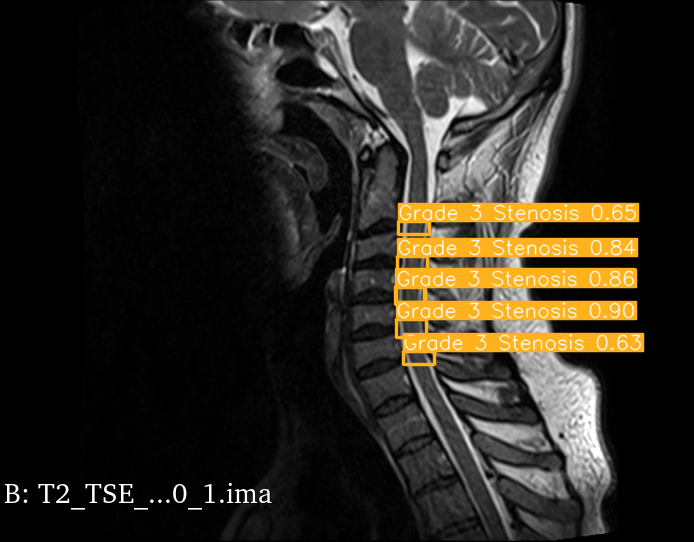

In [26]:
PREDS[2].show()